## __Check first before starting__

In [1]:
import os

Working_directory = os.path.normpath("/mnt/mydisk/Continual_Learning_JL/Continual_Learning/")
os.chdir(Working_directory)
print(f"Working directory: {os.getcwd()}")

Working directory: /mnt/mydisk/Continual_Learning_JL/Continual_Learning


## __All imports__

In [2]:
# Operating system and file management
import os
import shutil
import contextlib
import traceback
import gc
import copy
from collections import defaultdict
import subprocess
import time
import re, pickle
import scipy.io
from scipy.io import loadmat
from glob import glob

# Jupyter notebook widgets and display
import ipywidgets as widgets
from IPython.display import display

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Plotting and visualization
import matplotlib.pyplot as plt
from mpl_interactions import zoom_factory, panhandler

# Machine learning and preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pickle
from ta import trend, momentum, volatility, volume

# Mathematical and scientific computing
import math
from scipy.ndimage import gaussian_filter1d

# Type hinting
from typing import Callable, Tuple

# Deep learning with PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

## __Load & Explore Raw Dataset__
本段將確認 `.mat` / `.hea` 檔是否可正確讀取，並示範解析類別標籤。

In [3]:
def read_mat_file(filepath):
    mat = scipy.io.loadmat(filepath)
    return mat['val'].T  # shape = (N, 12)

def read_header_file(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
    
    for line in lines:
        if "Dx:" in line:
            dx_codes = line.strip().split(':')[-1].split(',')
            return [code.strip() for code in dx_codes]

    print(f"⚠️ No Dx line found in {filepath}")
    return []


BASE_DIR = "/mnt/mydisk/Continual_Learning_JL/Continual_Learning/Class_Incremental_CL/CPSC_CIL"
ECG_PATH = os.path.join(BASE_DIR, "datas")
MAX_LEN = 5000

# 測試讀取一筆資料

signal = read_mat_file(os.path.join(BASE_DIR, "datas/A0001.mat"))
labels = read_header_file(os.path.join(BASE_DIR, "datas/A0001.hea"))

print("Signal shape:", signal.shape)
print("Labels (SNOMED):", labels)

Signal shape: (7500, 12)
Labels (SNOMED): ['59118001']


## __Define Class Mapping for Periods__
本段定義每個 Period 所使用的類別與其對應的 SNOMED CT 標籤，並建立標籤轉換表。

In [4]:
# SNOMED CT to readable names
snomed_map = {
    "426783006": "NSR",    # 正常竇性心律
    "270492004": "I-AVB",  # 一度房室傳導阻滯
    "164889003": "AF",     # 心房纖維顫動
    "164909002": "LBBB",   # 左束支傳導阻滯
    "59118001":  "RBBB",   # 右束支傳導阻滯
    "284470004": "PAC",    # 心房早期搏動
    "164884008": "PVC",    # 室性早期搏動
    "429622005": "STD",    # ST 段壓低
    "164931005": "STE"     # ST 段抬高
}

# Period class mapping (固定 class 1 是「其他異常」直到 P4 移除)
period_label_map = {
    1: {"NSR": 0, "OTHER": 1},
    2: {"NSR": 0, "I-AVB": 2, "AF": 3, "OTHER": 1},
    3: {"NSR": 0, "I-AVB": 2, "AF": 3, "LBBB": 4, "RBBB": 5, "OTHER": 1},
    4: {"NSR": 0, "I-AVB": 2, "AF": 3, "LBBB": 4, "RBBB": 5, "PAC": 6, "PVC": 7, "STD": 8, "STE": 9, "OTHER": 1}
}

# __Balance Dataset__

## __Clean & Normalize Signals__
- 將原始信號統一轉為 (5000, 12)
- 做 channel-wise normalization
- 移除異常長度或無標籤資料

In [ ]:
def extract_class(label_list, period):
    mapped = [snomed_map.get(code) for code in label_list if code in snomed_map]

    if not mapped:
        return None  # 不屬於 9 類的直接排除

    current_map = period_label_map[period]

    # Period 1: Only NSR and OTHER
    if period == 1:
        return current_map["NSR"] if mapped == ["NSR"] else current_map.get("OTHER")

    # For other periods
    for name in mapped:
        if name in current_map and name != "OTHER":  # Look for specific classes first
            return current_map[name]
    
    # If no specific class found, mark as OTHER
    return current_map.get("OTHER") if "OTHER" in current_map else None

def preprocess_sample(file_prefix, period):
    try:
        signal = read_mat_file(os.path.join(ECG_PATH, file_prefix + ".mat"))
        if signal.shape[0] < MAX_LEN:
            return None, "too_short"
        signal = signal[:MAX_LEN, :]
        signal = (signal - np.mean(signal, axis=0)) / (np.std(signal, axis=0) + 1e-5)
        label = extract_class(read_header_file(os.path.join(ECG_PATH, file_prefix + ".hea")), period)
        if label is None:
            return None, "excluded"
        return (signal, label), "ok"
    except Exception as e:
        print(f"❌ Error parsing {file_prefix}: {e}")
        return None, "error"

## __Split Train/Test & Build Period Datasets__
- 切分訓練 / 測試集（固定 random seed）
- 依據 period label map 製作對應資料集

In [ ]:
def get_all_samples(period):
    """Collect all samples first and categorize them by class"""
    class_samples = {}
    too_short, excluded, total_error = 0, 0, 0

    all_ids = [os.path.basename(f).replace(".mat", "") for f in sorted(glob(os.path.join(ECG_PATH, "*.mat")))]

    for fid in all_ids:
        res, status = preprocess_sample(fid, period)
        if status == "too_short":
            too_short += 1
        elif status == "excluded":
            excluded += 1
        elif status == "ok":
            x, y = res
            if y not in class_samples:
                class_samples[y] = []
            class_samples[y].append(x)
        else:
            total_error += 1

    print(f"\n📄 Period {period} Raw Data Summary")
    print(f"  ✅ Total valid samples: {sum(len(samples) for samples in class_samples.values())}")
    print(f"  ⚠️ Too short        : {too_short}")
    print(f"  ⚠️ Excluded (not 9) : {excluded}")
    print(f"  ❌ Read errors      : {total_error}")
    
    return class_samples, too_short, excluded, total_error

def build_balanced_dataset(period, test_size=0.2):
    """Build dataset with balanced OTHER class"""
    class_samples, too_short, excluded, total_error = get_all_samples(period)
    
    # Get the class with label 1 (OTHER)
    other_samples = class_samples.get(1, [])
    
    # Find the maximum count of all other classes
    non_other_classes = {k: v for k, v in class_samples.items() if k != 1}
    if non_other_classes:  # Make sure there are other classes
        max_count = max(len(samples) for samples in non_other_classes.values())
    else:
        max_count = len(other_samples)  # Fallback, should not happen
    
    # Cap the OTHER class to the maximum count of other classes
    if len(other_samples) > max_count:
        print(f"  ⚠️ Limiting OTHER class from {len(other_samples)} to {max_count} samples")
        # Create indices for random selection
        np.random.seed(42)  # For reproducibility
        indices = np.random.permutation(len(other_samples))[:max_count]
        # Select samples using the indices
        other_samples = [other_samples[i] for i in indices]
        class_samples[1] = other_samples
    
    # Combine all samples
    data = []
    labels = []
    for label, samples in class_samples.items():
        data.extend(samples)
        labels.extend([label] * len(samples))
    
    # Shuffle the data with fixed random seed
    combined = list(zip(data, labels))
    np.random.seed(42)
    np.random.shuffle(combined)
    data, labels = zip(*combined)
    
    data, labels = np.array(data), np.array(labels)
    
    # Print final class distribution
    print_class_distribution(labels, {k: v for k, v in reversed(period_label_map[period].items())})
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        data, labels, test_size=test_size, stratify=labels, random_state=42
    )
    
    return X_train, y_train, X_test, y_test

def print_class_distribution(y, label_map):
    y = np.array(y).flatten()
    total = len(y)
    # Get labels sorted by their numerical value
    all_labels = sorted(set(label_map.values()))  

    print("\n📊 Class Distribution")
    for lbl in all_labels:
        count = np.sum(y == lbl)
        # Find the corresponding name for this label value
        label_names = [k for k, v in label_map.items() if v == lbl]
        name = label_names[0] if label_names else str(lbl)
        print(f"  ├─ Label {lbl:<2} ({name:<10}) → {count:>5} samples ({(count/total)*100:5.2f}%)")


## __Ex. Visualize Class Distribution per Period__

In [ ]:
X_train, y_train, X_test, y_test = build_balanced_dataset(period=1)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print_class_distribution(y_train, period_label_map[1])
print_class_distribution(y_test, period_label_map[1])

del X_train, y_train, X_test, y_test


📄 Period 1 Raw Data Summary
  ✅ Total valid samples: 6867
  ⚠️ Too short        : 10
  ⚠️ Excluded (not 9) : 0
  ❌ Read errors      : 0
  ⚠️ Limiting OTHER class from 5949 to 918 samples

📊 Class Distribution
  ├─ Label 0  (NSR       ) →   918 samples (50.00%)
  ├─ Label 1  (OTHER     ) →   918 samples (50.00%)
X_train shape: (1468, 5000, 12)
y_train shape: (1468,)

📊 Class Distribution
  ├─ Label 0  (NSR       ) →   734 samples (50.00%)
  ├─ Label 1  (OTHER     ) →   734 samples (50.00%)

📊 Class Distribution
  ├─ Label 0  (NSR       ) →   184 samples (50.00%)
  ├─ Label 1  (OTHER     ) →   184 samples (50.00%)


In [9]:
X_train, y_train, X_test, y_test = build_balanced_dataset(period=2)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print_class_distribution(y_train, period_label_map[2])
print_class_distribution(y_test, period_label_map[2])


📄 Period 2 Raw Data Summary
  ✅ Total valid samples: 6867
  ⚠️ Too short        : 10
  ⚠️ Excluded (not 9) : 0
  ❌ Read errors      : 0
  ⚠️ Limiting OTHER class from 4008 to 1220 samples

📊 Class Distribution
  ├─ Label 0  (NSR       ) →   918 samples (22.51%)
  ├─ Label 1  (OTHER     ) →  1220 samples (29.91%)
  ├─ Label 2  (I-AVB     ) →   721 samples (17.68%)
  ├─ Label 3  (AF        ) →  1220 samples (29.91%)
X_train shape: (3263, 5000, 12)
y_train shape: (3263,)

📊 Class Distribution
  ├─ Label 0  (NSR       ) →   734 samples (22.49%)
  ├─ Label 1  (OTHER     ) →   976 samples (29.91%)
  ├─ Label 2  (I-AVB     ) →   577 samples (17.68%)
  ├─ Label 3  (AF        ) →   976 samples (29.91%)

📊 Class Distribution
  ├─ Label 0  (NSR       ) →   184 samples (22.55%)
  ├─ Label 1  (OTHER     ) →   244 samples (29.90%)
  ├─ Label 2  (I-AVB     ) →   144 samples (17.65%)
  ├─ Label 3  (AF        ) →   244 samples (29.90%)


In [10]:
X_train, y_train, X_test, y_test = build_balanced_dataset(period=3)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print_class_distribution(y_train, period_label_map[3])
print_class_distribution(y_test, period_label_map[3])


📄 Period 3 Raw Data Summary
  ✅ Total valid samples: 6867
  ⚠️ Too short        : 10
  ⚠️ Excluded (not 9) : 0
  ❌ Read errors      : 0
  ⚠️ Limiting OTHER class from 2138 to 1672 samples

📊 Class Distribution
  ├─ Label 0  (NSR       ) →   918 samples (14.34%)
  ├─ Label 1  (OTHER     ) →  1672 samples (26.12%)
  ├─ Label 2  (I-AVB     ) →   721 samples (11.26%)
  ├─ Label 3  (AF        ) →  1220 samples (19.06%)
  ├─ Label 4  (LBBB      ) →   198 samples ( 3.09%)
  ├─ Label 5  (RBBB      ) →  1672 samples (26.12%)
X_train shape: (5120, 5000, 12)
y_train shape: (5120,)

📊 Class Distribution
  ├─ Label 0  (NSR       ) →   734 samples (14.34%)
  ├─ Label 1  (OTHER     ) →  1337 samples (26.11%)
  ├─ Label 2  (I-AVB     ) →   577 samples (11.27%)
  ├─ Label 3  (AF        ) →   976 samples (19.06%)
  ├─ Label 4  (LBBB      ) →   158 samples ( 3.09%)
  ├─ Label 5  (RBBB      ) →  1338 samples (26.13%)

📊 Class Distribution
  ├─ Label 0  (NSR       ) →   184 samples (14.36%)
  ├─ Label 1  

In [18]:
X_train, y_train, X_test, y_test = build_balanced_dataset(period=4)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print_class_distribution(y_train, period_label_map[4])
print_class_distribution(y_test, period_label_map[4])


📄 Period 4 Raw Data Summary
  ✅ Total valid samples: 6867
  ⚠️ Too short        : 10
  ⚠️ Excluded (not 9) : 0
  ❌ Read errors      : 0

📊 Class Distribution
  ├─ Label 0  (NSR       ) →   918 samples (13.37%)
  ├─ Label 1  (OTHER     ) →     0 samples ( 0.00%)
  ├─ Label 2  (I-AVB     ) →   721 samples (10.50%)
  ├─ Label 3  (AF        ) →  1220 samples (17.77%)
  ├─ Label 4  (LBBB      ) →   198 samples ( 2.88%)
  ├─ Label 5  (RBBB      ) →  1672 samples (24.35%)
  ├─ Label 6  (PAC       ) →   542 samples ( 7.89%)
  ├─ Label 7  (PVC       ) →   626 samples ( 9.12%)
  ├─ Label 8  (STD       ) →   785 samples (11.43%)
  ├─ Label 9  (STE       ) →   185 samples ( 2.69%)
X_train shape: (5493, 5000, 12)
y_train shape: (5493,)

📊 Class Distribution
  ├─ Label 0  (NSR       ) →   734 samples (13.36%)
  ├─ Label 1  (OTHER     ) →     0 samples ( 0.00%)
  ├─ Label 2  (I-AVB     ) →   577 samples (10.50%)
  ├─ Label 3  (AF        ) →   976 samples (17.77%)
  ├─ Label 4  (LBBB      ) →   158 s

## __Save Processed Dataset__
將每個 period 的訓練與測試集儲存為 `.npy` 或 `.pt`。

In [19]:
save_dir = os.path.join(BASE_DIR, "processed")
os.makedirs(save_dir, exist_ok=True)

for period in range(1, 5):
    print(f"\n{'='*50}")
    print(f"Processing Period {period}")
    print(f"{'='*50}")
    
    # Use the new balanced dataset function
    X_train, y_train, X_test, y_test = build_balanced_dataset(period=period)

    # 儲存
    np.save(os.path.join(save_dir, f"X_train_p{period}.npy"), X_train)
    np.save(os.path.join(save_dir, f"y_train_p{period}.npy"), y_train)
    np.save(os.path.join(save_dir, f"X_test_p{period}.npy"), X_test)
    np.save(os.path.join(save_dir, f"y_test_p{period}.npy"), y_test)

    print(f"\n✅ Period {period} saved. Train: {X_train.shape}, Test: {X_test.shape}")


Processing Period 1

📄 Period 1 Raw Data Summary
  ✅ Total valid samples: 6867
  ⚠️ Too short        : 10
  ⚠️ Excluded (not 9) : 0
  ❌ Read errors      : 0
  ⚠️ Limiting OTHER class from 5949 to 918 samples

📊 Class Distribution
  ├─ Label 0  (NSR       ) →   918 samples (50.00%)
  ├─ Label 1  (OTHER     ) →   918 samples (50.00%)

✅ Period 1 saved. Train: (1468, 5000, 12), Test: (368, 5000, 12)

Processing Period 2

📄 Period 2 Raw Data Summary
  ✅ Total valid samples: 6867
  ⚠️ Too short        : 10
  ⚠️ Excluded (not 9) : 0
  ❌ Read errors      : 0
  ⚠️ Limiting OTHER class from 4008 to 1220 samples

📊 Class Distribution
  ├─ Label 0  (NSR       ) →   918 samples (22.51%)
  ├─ Label 1  (OTHER     ) →  1220 samples (29.91%)
  ├─ Label 2  (I-AVB     ) →   721 samples (17.68%)
  ├─ Label 3  (AF        ) →  1220 samples (29.91%)

✅ Period 2 saved. Train: (3263, 5000, 12), Test: (816, 5000, 12)

Processing Period 3

📄 Period 3 Raw Data Summary
  ✅ Total valid samples: 6867
  ⚠️ Too shor

## __Ex. Check Dataset__

In [13]:
# 載入 period 4
save_dir = os.path.join(BASE_DIR, "processed")
X_train = np.load(os.path.join(save_dir, "X_train_p4.npy"))
y_train = np.load(os.path.join(save_dir, "y_train_p4.npy"))
X_test = np.load(os.path.join(save_dir, "X_test_p4.npy"))
y_test = np.load(os.path.join(save_dir, "y_test_p4.npy"))

print("✅ Loaded")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print_class_distribution(y_train, period_label_map[4])
print_class_distribution(y_test, period_label_map[4])


✅ Loaded
X_train shape: (5493, 5000, 12)
y_train shape: (5493,)

📊 Class Distribution
  ├─ Label 0  (NSR       ) →   734 samples (13.36%)
  ├─ Label 2  (I-AVB     ) →   577 samples (10.50%)
  ├─ Label 3  (AF        ) →   976 samples (17.77%)
  ├─ Label 4  (LBBB      ) →   158 samples ( 2.88%)
  ├─ Label 5  (RBBB      ) →  1337 samples (24.34%)
  ├─ Label 6  (PAC       ) →   434 samples ( 7.90%)
  ├─ Label 7  (PVC       ) →   501 samples ( 9.12%)
  ├─ Label 8  (STD       ) →   628 samples (11.43%)
  ├─ Label 9  (STE       ) →   148 samples ( 2.69%)

📊 Class Distribution
  ├─ Label 0  (NSR       ) →   184 samples (13.39%)
  ├─ Label 2  (I-AVB     ) →   144 samples (10.48%)
  ├─ Label 3  (AF        ) →   244 samples (17.76%)
  ├─ Label 4  (LBBB      ) →    40 samples ( 2.91%)
  ├─ Label 5  (RBBB      ) →   335 samples (24.38%)
  ├─ Label 6  (PAC       ) →   108 samples ( 7.86%)
  ├─ Label 7  (PVC       ) →   125 samples ( 9.10%)
  ├─ Label 8  (STD       ) →   157 samples (11.43%)
  ├─ Lab

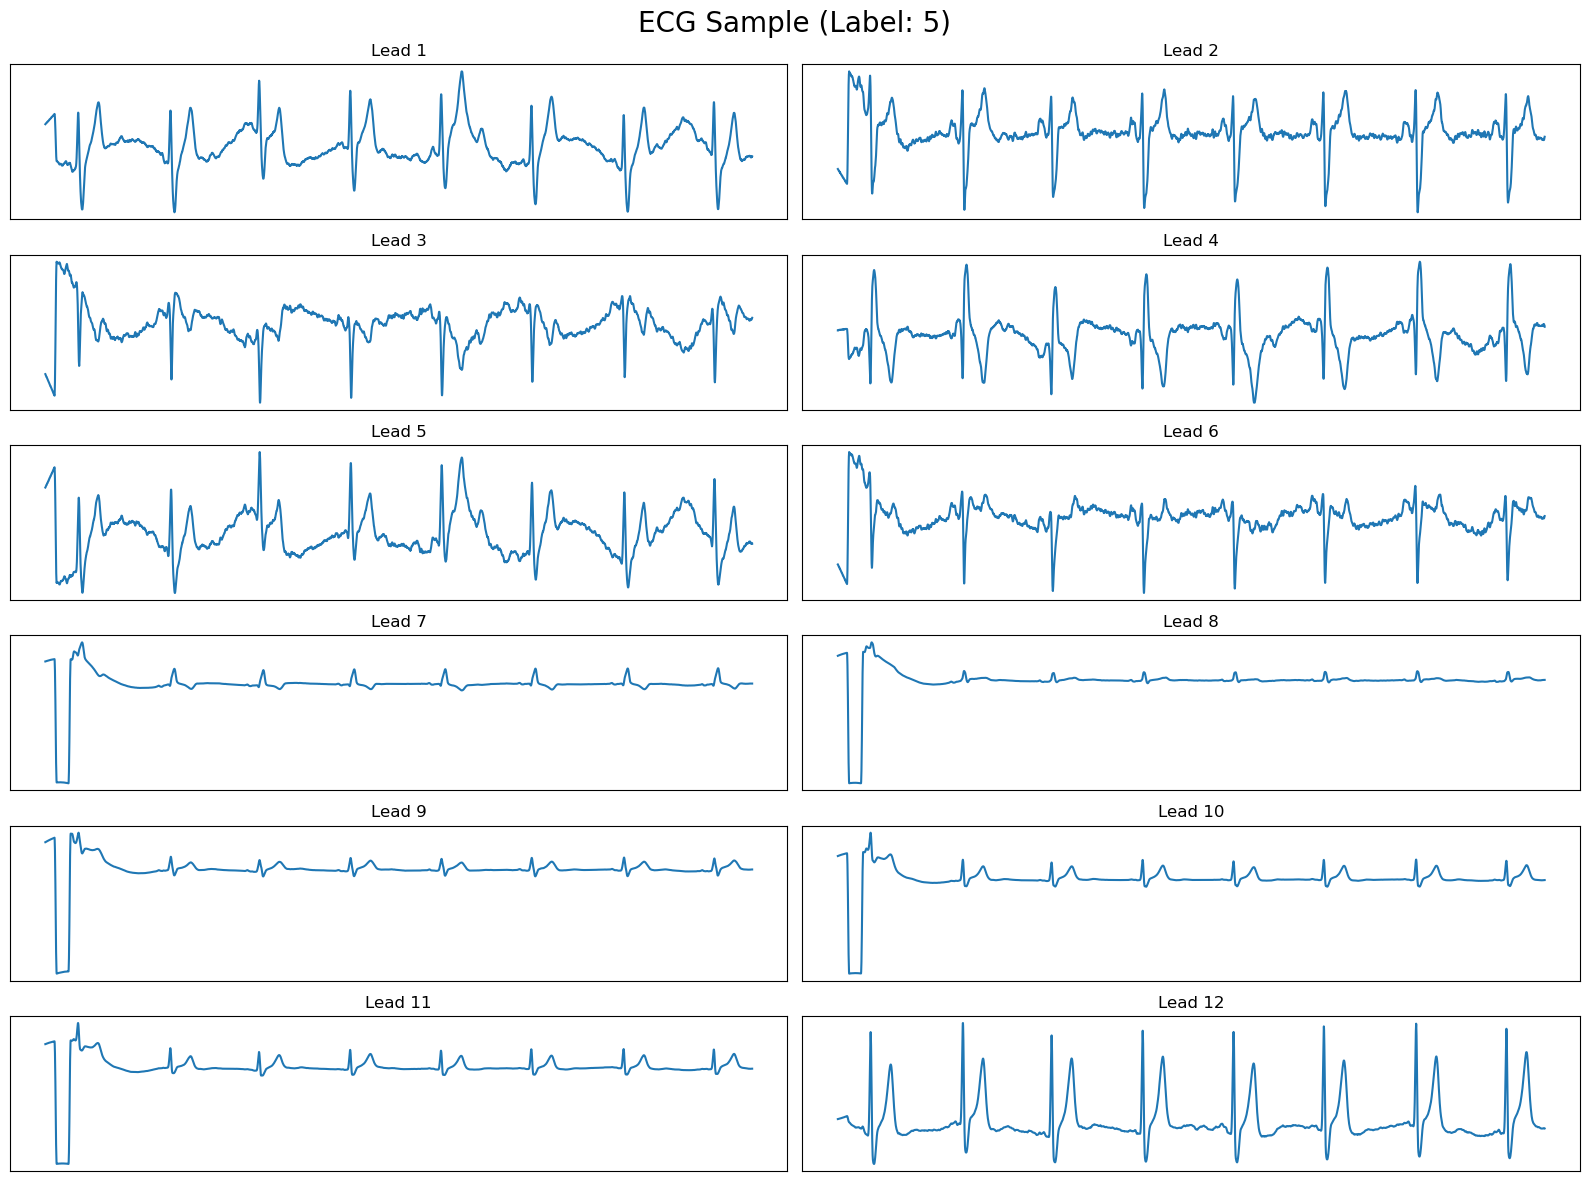

In [15]:
# 看第一筆
sample = X_train[0]  # shape = (5000, 12)
label = y_train[0]

plt.figure(figsize=(16, 12))
for i in range(12):
    plt.subplot(6, 2, i + 1)
    plt.plot(sample[:, i])
    plt.title(f"Lead {i+1}")
    plt.xticks([])
    plt.yticks([])
plt.suptitle(f"ECG Sample (Label: {label})", fontsize=20)
plt.tight_layout()
plt.show()

In [16]:
example_mat = os.path.join(ECG_PATH, "A0001.mat")
data = loadmat(example_mat)

raw_signal = data['val']  # shape = (12, N)

print("📂 .mat 內的 key:", list(data.keys()))  # 應為 ['val']
print("🧭 信號 shape:", raw_signal.shape)       # 12 導程 x N 筆資料點
print("🔢 資料型別:", raw_signal.dtype)         # 通常是 int16

# 額外說明
print("\n📝 說明：")
print("  - shape (12, 7500)：代表此筆 ECG 長 7500 個 time steps（= 15 秒，@500Hz）")
print("  - 共有 12 條導程（Lead 1~12），每條導程是一條 ECG 波形")

# 查看 Lead 1 前 10 個資料點（代表電位強度）
lead_1 = raw_signal[0]
print("\n🔬 Lead 1（前 10 點）:", lead_1[:10])

📂 .mat 內的 key: ['val']
🧭 信號 shape: (12, 7500)
🔢 資料型別: int16

📝 說明：
  - shape (12, 7500)：代表此筆 ECG 長 7500 個 time steps（= 15 秒，@500Hz）
  - 共有 12 條導程（Lead 1~12），每條導程是一條 ECG 波形

🔬 Lead 1（前 10 點）: [28 39 45 49 54 56 58 60 60 61]


# __Normal Dataset__

## __Clean & Normalize Signals__
- 將原始信號統一轉為 (5000, 12)
- 做 channel-wise normalization
- 移除異常長度或無標籤資料

In [5]:
def extract_class(label_list, period):
    mapped = [snomed_map.get(code) for code in label_list if code in snomed_map]

    if not mapped:
        return None  # 不屬於 9 類的直接排除

    current_map = period_label_map[period]

    if period == 1:
        return current_map["NSR"] if mapped == ["NSR"] else current_map.get("OTHER")

    for name in mapped:
        if name in current_map:
            return current_map[name]
    return current_map.get("OTHER") if "OTHER" in current_map else None

def preprocess_sample(file_prefix, period):
    try:
        signal = read_mat_file(os.path.join(ECG_PATH, file_prefix + ".mat"))
        if signal.shape[0] < MAX_LEN:
            return None, "too_short"
        signal = signal[:MAX_LEN, :]
        signal = (signal - np.mean(signal, axis=0)) / (np.std(signal, axis=0) + 1e-5)
        label = extract_class(read_header_file(os.path.join(ECG_PATH, file_prefix + ".hea")), period)
        if label is None:
            return None, "excluded"
        return (signal, label), "ok"
    except Exception as e:
        print(f"❌ Error parsing {file_prefix}: {e}")
        return None, "error"

## __Split Train/Test & Build Period Datasets__
- 切分訓練 / 測試集（固定 random seed）
- 依據 period label map 製作對應資料集

In [6]:
def build_dataset(period, test_size=0.2):
    data, labels = [], []
    too_short, excluded, total_error = 0, 0, 0

    all_ids = [os.path.basename(f).replace(".mat", "") for f in sorted(glob(os.path.join(ECG_PATH, "*.mat")))]

    for fid in all_ids:
        res, status = preprocess_sample(fid, period)
        if status == "too_short":
            too_short += 1
        elif status == "excluded":
            excluded += 1
        elif status == "ok":
            x, y = res
            data.append(x)
            labels.append(y)
        else:
            total_error += 1

    print(f"\n📄 Period {period} Summary")
    print(f"  ✅ Used samples     : {len(data)}")
    print(f"  ⚠️ Too short        : {too_short}")
    print(f"  ⚠️ Excluded (not 9) : {excluded}")
    print(f"  ❌ Read errors      : {total_error}")

    data, labels = np.array(data), np.array(labels)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, stratify=labels, random_state=42)
    return X_train, y_train, X_test, y_test

def print_class_distribution(y, label_map):
    y = np.array(y).flatten()
    total = len(y)
    all_labels = sorted(label_map.values())  # 確保順序一致

    print("\n📊 Class Distribution")
    for lbl in all_labels:
        count = np.sum(y == lbl)
        label = [k for k, v in label_map.items() if v == lbl]
        name = label[0] if label else str(lbl)
        print(f"  ├─ Label {lbl:<2} ({name:<10}) → {count:>5} samples ({(count/total)*100:5.2f}%)")

## __Ex. Visualize Class Distribution per Period__

In [8]:
X_train, y_train, X_test, y_test = build_dataset(period=1)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print_class_distribution(y_train, period_label_map[1])
print_class_distribution(y_test, period_label_map[1])

del X_train, y_train, X_test, y_test


📄 Period 1 Summary
  ✅ Used samples     : 6867
  ⚠️ Too short        : 10
  ⚠️ Excluded (not 9) : 0
  ❌ Read errors      : 0
X_train shape: (5493, 5000, 12)
y_train shape: (5493,)

📊 Class Distribution
  ├─ Label 0  (NSR       ) →   734 samples (13.36%)
  ├─ Label 1  (OTHER     ) →  4759 samples (86.64%)

📊 Class Distribution
  ├─ Label 0  (NSR       ) →   184 samples (13.39%)
  ├─ Label 1  (OTHER     ) →  1190 samples (86.61%)


In [9]:
X_train, y_train, X_test, y_test = build_dataset(period=2)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print_class_distribution(y_train, period_label_map[2])
print_class_distribution(y_test, period_label_map[2])

del X_train, y_train, X_test, y_test


📄 Period 2 Summary
  ✅ Used samples     : 6867
  ⚠️ Too short        : 10
  ⚠️ Excluded (not 9) : 0
  ❌ Read errors      : 0
X_train shape: (5493, 5000, 12)
y_train shape: (5493,)

📊 Class Distribution
  ├─ Label 0  (NSR       ) →   734 samples (13.36%)
  ├─ Label 1  (OTHER     ) →  3206 samples (58.37%)
  ├─ Label 2  (I-AVB     ) →   577 samples (10.50%)
  ├─ Label 3  (AF        ) →   976 samples (17.77%)

📊 Class Distribution
  ├─ Label 0  (NSR       ) →   184 samples (13.39%)
  ├─ Label 1  (OTHER     ) →   802 samples (58.37%)
  ├─ Label 2  (I-AVB     ) →   144 samples (10.48%)
  ├─ Label 3  (AF        ) →   244 samples (17.76%)


In [10]:
X_train, y_train, X_test, y_test = build_dataset(period=3)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print_class_distribution(y_train, period_label_map[3])
print_class_distribution(y_test, period_label_map[3])

del X_train, y_train, X_test, y_test


📄 Period 3 Summary
  ✅ Used samples     : 6867
  ⚠️ Too short        : 10
  ⚠️ Excluded (not 9) : 0
  ❌ Read errors      : 0
X_train shape: (5493, 5000, 12)
y_train shape: (5493,)

📊 Class Distribution
  ├─ Label 0  (NSR       ) →   734 samples (13.36%)
  ├─ Label 1  (OTHER     ) →  1710 samples (31.13%)
  ├─ Label 2  (I-AVB     ) →   577 samples (10.50%)
  ├─ Label 3  (AF        ) →   976 samples (17.77%)
  ├─ Label 4  (LBBB      ) →   158 samples ( 2.88%)
  ├─ Label 5  (RBBB      ) →  1338 samples (24.36%)

📊 Class Distribution
  ├─ Label 0  (NSR       ) →   184 samples (13.39%)
  ├─ Label 1  (OTHER     ) →   428 samples (31.15%)
  ├─ Label 2  (I-AVB     ) →   144 samples (10.48%)
  ├─ Label 3  (AF        ) →   244 samples (17.76%)
  ├─ Label 4  (LBBB      ) →    40 samples ( 2.91%)
  ├─ Label 5  (RBBB      ) →   334 samples (24.31%)


In [11]:
X_train, y_train, X_test, y_test = build_dataset(period=4)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print_class_distribution(y_train, period_label_map[4])
print_class_distribution(y_test, period_label_map[4])

del X_train, y_train, X_test, y_test


📄 Period 4 Summary
  ✅ Used samples     : 6867
  ⚠️ Too short        : 10
  ⚠️ Excluded (not 9) : 0
  ❌ Read errors      : 0
X_train shape: (5493, 5000, 12)
y_train shape: (5493,)

📊 Class Distribution
  ├─ Label 0  (NSR       ) →   734 samples (13.36%)
  ├─ Label 1  (OTHER     ) →     0 samples ( 0.00%)
  ├─ Label 2  (I-AVB     ) →   577 samples (10.50%)
  ├─ Label 3  (AF        ) →   976 samples (17.77%)
  ├─ Label 4  (LBBB      ) →   158 samples ( 2.88%)
  ├─ Label 5  (RBBB      ) →  1337 samples (24.34%)
  ├─ Label 6  (PAC       ) →   434 samples ( 7.90%)
  ├─ Label 7  (PVC       ) →   501 samples ( 9.12%)
  ├─ Label 8  (STD       ) →   628 samples (11.43%)
  ├─ Label 9  (STE       ) →   148 samples ( 2.69%)

📊 Class Distribution
  ├─ Label 0  (NSR       ) →   184 samples (13.39%)
  ├─ Label 1  (OTHER     ) →     0 samples ( 0.00%)
  ├─ Label 2  (I-AVB     ) →   144 samples (10.48%)
  ├─ Label 3  (AF        ) →   244 samples (17.76%)
  ├─ Label 4  (LBBB      ) →    40 samples ( 2.

## __Save Processed Dataset__
將每個 period 的訓練與測試集儲存為 `.npy` 或 `.pt`。

In [12]:
save_dir = os.path.join(BASE_DIR, "processed_normal")
os.makedirs(save_dir, exist_ok=True)

for period in range(1, 5):
    print(f"\n{'='*50}")
    print(f"Processing Period {period}")
    print(f"{'='*50}")
    
    # Use the new balanced dataset function
    X_train, y_train, X_test, y_test = build_dataset(period=period)

    # 儲存
    np.save(os.path.join(save_dir, f"X_train_p{period}.npy"), X_train)
    np.save(os.path.join(save_dir, f"y_train_p{period}.npy"), y_train)
    np.save(os.path.join(save_dir, f"X_test_p{period}.npy"), X_test)
    np.save(os.path.join(save_dir, f"y_test_p{period}.npy"), y_test)

    print(f"\n✅ Period {period} saved. Train: {X_train.shape}, Test: {X_test.shape}")


Processing Period 1

📄 Period 1 Summary
  ✅ Used samples     : 6867
  ⚠️ Too short        : 10
  ⚠️ Excluded (not 9) : 0
  ❌ Read errors      : 0

✅ Period 1 saved. Train: (5493, 5000, 12), Test: (1374, 5000, 12)

Processing Period 2

📄 Period 2 Summary
  ✅ Used samples     : 6867
  ⚠️ Too short        : 10
  ⚠️ Excluded (not 9) : 0
  ❌ Read errors      : 0

✅ Period 2 saved. Train: (5493, 5000, 12), Test: (1374, 5000, 12)

Processing Period 3

📄 Period 3 Summary
  ✅ Used samples     : 6867
  ⚠️ Too short        : 10
  ⚠️ Excluded (not 9) : 0
  ❌ Read errors      : 0

✅ Period 3 saved. Train: (5493, 5000, 12), Test: (1374, 5000, 12)

Processing Period 4

📄 Period 4 Summary
  ✅ Used samples     : 6867
  ⚠️ Too short        : 10
  ⚠️ Excluded (not 9) : 0
  ❌ Read errors      : 0

✅ Period 4 saved. Train: (5493, 5000, 12), Test: (1374, 5000, 12)


## __Ex. Check Dataset__

In [14]:
# 載入 period 4
save_dir = os.path.join(BASE_DIR, "processed_normal")
X_train = np.load(os.path.join(save_dir, "X_train_p1.npy"))
y_train = np.load(os.path.join(save_dir, "y_train_p1.npy"))
X_test = np.load(os.path.join(save_dir, "X_test_p1.npy"))
y_test = np.load(os.path.join(save_dir, "y_test_p1.npy"))

print("✅ Loaded")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print_class_distribution(y_train, period_label_map[4])
print_class_distribution(y_test, period_label_map[4])


✅ Loaded
X_train shape: (5493, 5000, 12)
y_train shape: (5493,)

📊 Class Distribution
  ├─ Label 0  (NSR       ) →   734 samples (13.36%)
  ├─ Label 1  (OTHER     ) →  4759 samples (86.64%)
  ├─ Label 2  (I-AVB     ) →     0 samples ( 0.00%)
  ├─ Label 3  (AF        ) →     0 samples ( 0.00%)
  ├─ Label 4  (LBBB      ) →     0 samples ( 0.00%)
  ├─ Label 5  (RBBB      ) →     0 samples ( 0.00%)
  ├─ Label 6  (PAC       ) →     0 samples ( 0.00%)
  ├─ Label 7  (PVC       ) →     0 samples ( 0.00%)
  ├─ Label 8  (STD       ) →     0 samples ( 0.00%)
  ├─ Label 9  (STE       ) →     0 samples ( 0.00%)

📊 Class Distribution
  ├─ Label 0  (NSR       ) →   184 samples (13.39%)
  ├─ Label 1  (OTHER     ) →  1190 samples (86.61%)
  ├─ Label 2  (I-AVB     ) →     0 samples ( 0.00%)
  ├─ Label 3  (AF        ) →     0 samples ( 0.00%)
  ├─ Label 4  (LBBB      ) →     0 samples ( 0.00%)
  ├─ Label 5  (RBBB      ) →     0 samples ( 0.00%)
  ├─ Label 6  (PAC       ) →     0 samples ( 0.00%)
  ├─ Lab

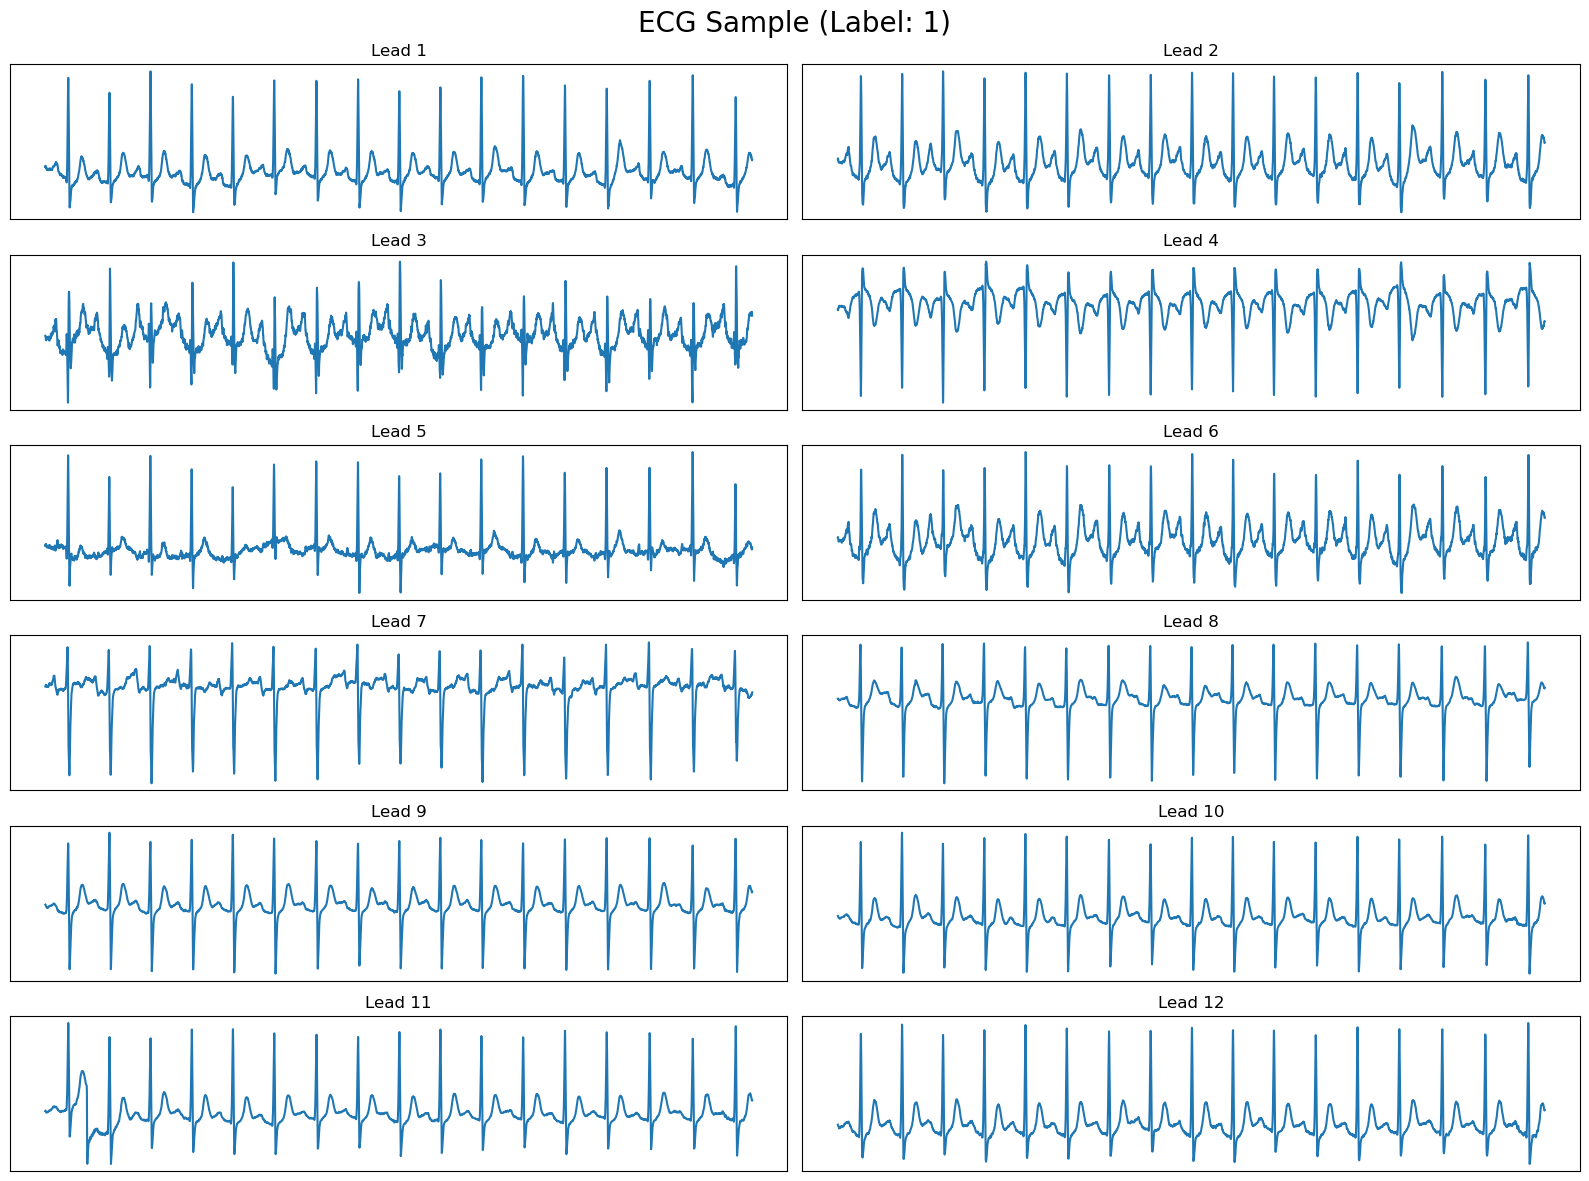

In [15]:
# 看第一筆
sample = X_train[0]  # shape = (5000, 12)
label = y_train[0]

plt.figure(figsize=(16, 12))
for i in range(12):
    plt.subplot(6, 2, i + 1)
    plt.plot(sample[:, i])
    plt.title(f"Lead {i+1}")
    plt.xticks([])
    plt.yticks([])
plt.suptitle(f"ECG Sample (Label: {label})", fontsize=20)
plt.tight_layout()
plt.show()

In [16]:
example_mat = os.path.join(ECG_PATH, "A0001.mat")
data = loadmat(example_mat)

raw_signal = data['val']  # shape = (12, N)

print("📂 .mat 內的 key:", list(data.keys()))  # 應為 ['val']
print("🧭 信號 shape:", raw_signal.shape)       # 12 導程 x N 筆資料點
print("🔢 資料型別:", raw_signal.dtype)         # 通常是 int16

# 額外說明
print("\n📝 說明：")
print("  - shape (12, 7500)：代表此筆 ECG 長 7500 個 time steps（= 15 秒，@500Hz）")
print("  - 共有 12 條導程（Lead 1~12），每條導程是一條 ECG 波形")

# 查看 Lead 1 前 10 個資料點（代表電位強度）
lead_1 = raw_signal[0]
print("\n🔬 Lead 1（前 10 點）:", lead_1[:10])

📂 .mat 內的 key: ['val']
🧭 信號 shape: (12, 7500)
🔢 資料型別: int16

📝 說明：
  - shape (12, 7500)：代表此筆 ECG 長 7500 個 time steps（= 15 秒，@500Hz）
  - 共有 12 條導程（Lead 1~12），每條導程是一條 ECG 波形

🔬 Lead 1（前 10 點）: [28 39 45 49 54 56 58 60 60 61]
